In [1]:
from diffusers import DDPMPipeline
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from utils import plot_image
from tqdm import tqdm
import numpy as np

/users/eleves-a/2021/gaetan.narozniak/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-10 13:47:18.878320: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 13:47:18.886448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744285638.896151   19862 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744285638.899069   19862 cuda_

In [2]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

model_id = "google/ddpm-ema-celebahq-256"
ddpm = DDPMPipeline.from_pretrained(model_id)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("using device: ", device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]An error occurred while trying to fetch /users/eleves-a/2021/gaetan.narozniak/.cache/huggingface/hub/models--google--ddpm-ema-celebahq-256/snapshots/4cb6117472e6e4f45c5afe606b101858c27c3802: Error no file named diffusion_pytorch_model.safetensors found in directory /users/eleves-a/2021/gaetan.narozniak/.cache/huggingface/hub/models--google--ddpm-ema-celebahq-256/snapshots/4cb6117472e6e4f45c5afe606b101858c27c3802.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 35.36it/s]

using device:  cuda:0


 21%|██        | 6/29 [00:00<00:00, 23.35it/s]

100%|██████████| 29/29 [00:01<00:00, 21.56it/s]


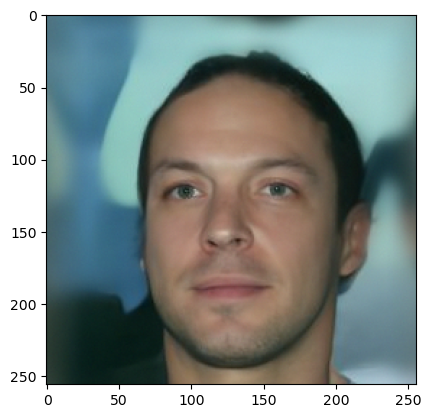

In [20]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

image = Image.open("pictures/gaetan.jpeg").convert("RGB")
tensor_image = transform(image).unsqueeze(0)
tensor_image.shape

unet = ddpm.unet.to(device)
scheduler = ddpm.scheduler
scheduler.set_timesteps(30)

x = torch.randn((1, 3, 256, 256)).to(device)
timesteps = scheduler.timesteps

for i in tqdm(range(len(timesteps)-1)):
    t = timesteps[i]
    t_next = timesteps[i+1]
    alpha_bar_t = scheduler.alphas_cumprod[t]
    alpha_bar_t_next = scheduler.alphas_cumprod[t_next]
    custom_noise_scale = (((1 - alpha_bar_t) / (1 - alpha_bar_t_next)) * 
                          (1 - (alpha_bar_t_next / alpha_bar_t))).sqrt()
    with torch.no_grad():
        noise_pred = unet(x, t).sample
        x = scheduler.step(noise_pred, t, x).prev_sample

plot_image(x)